<a href="https://colab.research.google.com/github/Hqrukq/informationalpha/blob/Hqrukq/%E6%83%85%E5%A0%B1%CE%B1%E3%83%97%E3%83%AD%E3%82%B8%E3%82%A7%E3%82%AF%E3%83%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
from tensorflow.python.keras.models import load_model
model_final = load_model("/content/drive/MyDrive/model")

In [ ]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
def rectinside(bb1,bb2):
  if bb1["x1"]<bb2["x1"] and bb1["x2"]>bb2["x2"] and bb1["y1"]<bb2["y1"] and bb1["y2"]>bb2["y2"]:
    return 1
  else:
    return 0

In [ ]:
colors = [(0,255,0),(0,0,255),(255,0,0)]
prices = [80,100,150]#消しゴム、シャー芯、ペンの順。値段は適当

25
2
合計 300 円です


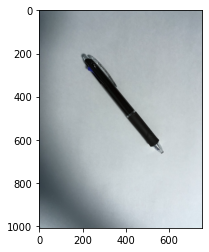

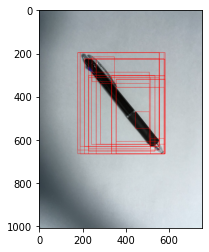

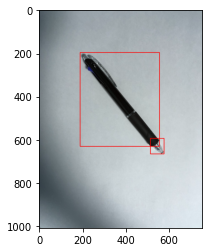

In [ ]:
num = "1"
imgepath 
img = cv2.imread("/content/drive/MyDrive/test/resized/test0.jpg")
im = img.copy()
plt.imshow(im)
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()
rectvals = []
for e,result in enumerate(ssresults):
  if e < 2000:
    x,y,w,h = result
    if w>60 and h>60:
      timage = imout[y:y+h,x:x+w]
      resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
      img = np.expand_dims(resized, axis=0)
      out= model_final.predict(img)
      if np.argmax(out[0])!= 0 and np.amax(out[0][:4])>0.7:
        cv2.rectangle(imout, (x, y), (x+w, y+h), colors[np.argmax(out[0])-1], 1, cv2.LINE_AA)
        rectvals.append({"x1":x,"x2":x+w,"y1":y,"y2":y+h,"labels":np.argmax(out[0]),"prob":np.amax(out[0][:4])})
plt.figure()
plt.imshow(imout)

rect_vals= rectvals
rect_sorted = sorted(rect_vals, key=lambda x: x['prob'],reverse=True)

img = cv2.imread("/content/drive/MyDrive/test/resized/test0.jpg")
imout = img.copy()

bb1 = {"x1":0,"x2":0,"y1":0,"y2":0}
bb2 = {"x1":0,"x2":0,"y1":0,"y2":0}
rectresult = []
for i in range(len(rect_sorted)-2):
  if rect_sorted[i]["labels"]>0:
    rectresult.append(rect_sorted[i])
    bb1["x1"] = rect_sorted[i]["x1"]
    bb1["x2"] = rect_sorted[i]["x2"]
    bb1["y1"] = rect_sorted[i]["y1"]
    bb1["y2"] = rect_sorted[i]["y2"]
    for k in range(i+1,len(rect_sorted)-1):
      if rect_sorted[i]["labels"]==rect_sorted[k]["labels"]:
        bb2["x1"] = rect_sorted[k]["x1"] 
        bb2["x2"] = rect_sorted[k]["x2"] 
        bb2["y1"] = rect_sorted[k]["y1"] 
        bb2["y2"] = rect_sorted[k]["y2"]
        IOU = get_iou(bb1,bb2)
        if IOU > 0.3:
          rect_sorted[k]["labels"] = -1
        elif rectinside(bb1,bb2):
          rect_sorted[k]["labels"] = -1

#print(len(rect_sorted))
#print(len(rectresult))
for rect in range(len(rectresult)):
  x1,x2,y1,y2,labels = rectresult[rect]["x1"],rectresult[rect]["x2"],rectresult[rect]["y1"],rectresult[rect]["y2"],rectresult[rect]["labels"]
  cv2.rectangle(imout, (x1,y1),(x2,y2),colors[labels - 1] , 2)

plt.figure()
plt.imshow(imout)

sum = 0
for i in range(len(rectresult)):
  sum = sum + prices[rectresult[i]["labels"]-1]
print("合計",sum,"円です")